In [6]:
# import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

In [8]:
# using "tensorflow" as backend
os.environ["KERAS_BACKEND"] = "tensorflow"

In [9]:
# to reproduce results
np.random.seed(10)

In [10]:
# dim of random noise vector
random_dim = 100

In [15]:
def load_mnist_data():
    '''
    return normalized mnist data in shape (60000, 784)
    '''
    # loading the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # normalize the inputs in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert x_trian shape 
    # (60000, 28, 28) to (60000, 784)
    
    x_train = x_train.reshape(60000, 784)
    
    return (x_train, y_train, x_test, y_test)
     

In [17]:
def get_optimizer(lr=0.0002, beta_1=0.5):
    '''
    return Adam optimizer.
    ---params---
    lr
    beta_1 
    '''
    return Adam(lr=lr, beta_1=beta_1)

In [27]:
def get_generator(optimizer):
    '''
    Generator Function
    ---params---
    optimizer
    '''
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim,
                        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return generator

In [28]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    
    discriminator.add(Dense(1024, input_dim=784,
                            kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return discriminator

In [29]:
def gan_network(discriminator, generator, random_dim, optimizer):
    '''
    building the GAN network
    ---params---
    discriminator
    generator
    random_dim
    optimizer
    '''
    # Initially set trainable to False since we only want to train
    # either the generator or discrimnator
    discriminator.trainable = False
    
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    
    # the output the generator (an image)
    x = generator(gan_input)
    
    # get the output of the discriminator 
    # (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gan

In [30]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    '''
    Plot a wall of generated images.
    ---params---
    epoch
    generator
    examples
    dim=(m,n)
    figsize=(m,n)
    '''
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i],
                   interpolation='nearest',
                   cmap='gray_r')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('generated_images/gan_generated_image_epoch_%d.png' % epoch)

In [38]:
def train_GAN(epochs=1, batch_size=128):
    '''
    Training the Generative Model.
    ---params---
    epochs
    batch_size
    '''
    # loading the training and testing data
    x_train, y_train, x_test, y_test = load_mnist_data()
    
    # split the training data into batches of size 128
    batch_count = int(x_train.shape[0] / batch_size)
    
    # Building our GAN network
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = gan_network(discriminator, generator, random_dim, adam)
    
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                    size=batch_size)]
            
            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
    
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # one-sided label smoothing
            y_dis[:batch_size] = 0.9
            
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
            
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

--------------- Epoch 1 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:14<00:00, 33.36it/s]


--------------- Epoch 2 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.33it/s]


--------------- Epoch 3 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.64it/s]


--------------- Epoch 4 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.48it/s]


--------------- Epoch 5 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.59it/s]


--------------- Epoch 6 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.70it/s]


--------------- Epoch 7 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.22it/s]


--------------- Epoch 8 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.22it/s]


--------------- Epoch 9 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.68it/s]


--------------- Epoch 10 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.58it/s]


--------------- Epoch 11 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.73it/s]


--------------- Epoch 12 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.60it/s]


--------------- Epoch 13 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.74it/s]


--------------- Epoch 14 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.22it/s]


--------------- Epoch 15 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.03it/s]


--------------- Epoch 16 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.00it/s]


--------------- Epoch 17 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.48it/s]


--------------- Epoch 18 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.39it/s]


--------------- Epoch 19 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.13it/s]


--------------- Epoch 20 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.64it/s]


--------------- Epoch 21 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.24it/s]


--------------- Epoch 22 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.31it/s]


--------------- Epoch 23 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.74it/s]


--------------- Epoch 24 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.25it/s]


--------------- Epoch 25 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 54.80it/s]


--------------- Epoch 26 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.67it/s]


--------------- Epoch 27 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.07it/s]


--------------- Epoch 28 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.84it/s]


--------------- Epoch 29 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.83it/s]


--------------- Epoch 30 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.31it/s]


--------------- Epoch 31 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.73it/s]


--------------- Epoch 32 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.21it/s]


--------------- Epoch 33 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.84it/s]


--------------- Epoch 34 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.30it/s]


--------------- Epoch 35 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.85it/s]


--------------- Epoch 36 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.29it/s]


--------------- Epoch 37 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.74it/s]


--------------- Epoch 38 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.26it/s]


--------------- Epoch 39 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.06it/s]


--------------- Epoch 40 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.14it/s]


--------------- Epoch 41 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.75it/s]


--------------- Epoch 42 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.28it/s]


--------------- Epoch 43 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.88it/s]


--------------- Epoch 44 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.28it/s]


--------------- Epoch 45 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.80it/s]


--------------- Epoch 46 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.33it/s]


--------------- Epoch 47 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.02it/s]


--------------- Epoch 48 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.19it/s]


--------------- Epoch 49 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.09it/s]


--------------- Epoch 50 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.19it/s]


--------------- Epoch 51 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 50.36it/s]


--------------- Epoch 52 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 54.03it/s]


--------------- Epoch 53 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.87it/s]


--------------- Epoch 54 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.22it/s]


--------------- Epoch 55 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.94it/s]


--------------- Epoch 56 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.10it/s]


--------------- Epoch 57 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 55.14it/s]


--------------- Epoch 58 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.49it/s]


--------------- Epoch 59 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.67it/s]


--------------- Epoch 60 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 54.37it/s]


--------------- Epoch 61 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.13it/s]


--------------- Epoch 62 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.10it/s]


--------------- Epoch 63 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.27it/s]


--------------- Epoch 64 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.12it/s]


--------------- Epoch 65 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.33it/s]


--------------- Epoch 66 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.16it/s]


--------------- Epoch 67 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.62it/s]


--------------- Epoch 68 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.12it/s]


--------------- Epoch 69 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.70it/s]


--------------- Epoch 70 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.15it/s]


--------------- Epoch 71 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.74it/s]


--------------- Epoch 72 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.20it/s]


--------------- Epoch 73 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.84it/s]


--------------- Epoch 74 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.31it/s]


--------------- Epoch 75 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.93it/s]


--------------- Epoch 76 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.25it/s]


--------------- Epoch 77 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.94it/s]


--------------- Epoch 78 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.32it/s]


--------------- Epoch 79 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.16it/s]


--------------- Epoch 80 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.18it/s]


--------------- Epoch 81 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.73it/s]


--------------- Epoch 82 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.36it/s]


--------------- Epoch 83 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.93it/s]


--------------- Epoch 84 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.28it/s]


--------------- Epoch 85 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.80it/s]


--------------- Epoch 86 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.17it/s]


--------------- Epoch 87 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.82it/s]


--------------- Epoch 88 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.22it/s]


--------------- Epoch 89 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.88it/s]


--------------- Epoch 90 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.19it/s]


--------------- Epoch 91 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.00it/s]


--------------- Epoch 92 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.15it/s]


--------------- Epoch 93 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.03it/s]


--------------- Epoch 94 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.95it/s]


--------------- Epoch 95 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.15it/s]


--------------- Epoch 96 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.88it/s]


--------------- Epoch 97 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.20it/s]


--------------- Epoch 98 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.83it/s]


--------------- Epoch 99 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.15it/s]


--------------- Epoch 100 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.62it/s]


--------------- Epoch 101 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.61it/s]


--------------- Epoch 102 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.16it/s]


--------------- Epoch 103 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.69it/s]


--------------- Epoch 104 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.19it/s]


--------------- Epoch 105 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.93it/s]


--------------- Epoch 106 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.96it/s]


--------------- Epoch 107 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.01it/s]


--------------- Epoch 108 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.73it/s]


--------------- Epoch 109 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.11it/s]


--------------- Epoch 110 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.73it/s]


--------------- Epoch 111 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.15it/s]


--------------- Epoch 112 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.58it/s]


--------------- Epoch 113 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.14it/s]


--------------- Epoch 114 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.79it/s]


--------------- Epoch 115 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.12it/s]


--------------- Epoch 116 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.80it/s]


--------------- Epoch 117 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 46.97it/s]


--------------- Epoch 118 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.98it/s]


--------------- Epoch 119 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.90it/s]


--------------- Epoch 120 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.12it/s]


--------------- Epoch 121 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 52.79it/s]


--------------- Epoch 122 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.23it/s]


--------------- Epoch 123 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.59it/s]


--------------- Epoch 124 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.86it/s]


--------------- Epoch 125 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 53.32it/s]


--------------- Epoch 126 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.59it/s]


--------------- Epoch 127 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 54.23it/s]


--------------- Epoch 128 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 55.49it/s]


--------------- Epoch 129 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.17it/s]


--------------- Epoch 130 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.31it/s]


--------------- Epoch 131 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.51it/s]


--------------- Epoch 132 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.17it/s]


--------------- Epoch 133 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 52.49it/s]


--------------- Epoch 134 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.43it/s]


--------------- Epoch 135 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.96it/s]


--------------- Epoch 136 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.63it/s]


--------------- Epoch 137 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.45it/s]


--------------- Epoch 138 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.93it/s]


--------------- Epoch 139 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.67it/s]


--------------- Epoch 140 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.82it/s]


--------------- Epoch 141 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.50it/s]


--------------- Epoch 142 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.18it/s]


--------------- Epoch 143 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.07it/s]


--------------- Epoch 144 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.76it/s]


--------------- Epoch 145 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.03it/s]


--------------- Epoch 146 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.99it/s]


--------------- Epoch 147 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.70it/s]


--------------- Epoch 148 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.49it/s]


--------------- Epoch 149 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 55.46it/s]


--------------- Epoch 150 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.91it/s]


--------------- Epoch 151 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.10it/s]


--------------- Epoch 152 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.11it/s]


--------------- Epoch 153 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 49.49it/s]


--------------- Epoch 154 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.71it/s]


--------------- Epoch 155 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.07it/s]


--------------- Epoch 156 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.18it/s]


--------------- Epoch 157 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.05it/s]


--------------- Epoch 158 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.88it/s]


--------------- Epoch 159 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.94it/s]


--------------- Epoch 160 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.05it/s]


--------------- Epoch 161 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.27it/s]


--------------- Epoch 162 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.94it/s]


--------------- Epoch 163 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.65it/s]


--------------- Epoch 164 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.17it/s]


--------------- Epoch 165 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.74it/s]


--------------- Epoch 166 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 49.55it/s]


--------------- Epoch 167 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.08it/s]


--------------- Epoch 168 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 52.22it/s]


--------------- Epoch 169 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.04it/s]


--------------- Epoch 170 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.75it/s]


--------------- Epoch 171 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.11it/s]


--------------- Epoch 172 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 52.61it/s]


--------------- Epoch 173 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.21it/s]


--------------- Epoch 174 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.66it/s]


--------------- Epoch 175 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.10it/s]


--------------- Epoch 176 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.68it/s]


--------------- Epoch 177 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.13it/s]


--------------- Epoch 178 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.72it/s]


--------------- Epoch 179 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.17it/s]


--------------- Epoch 180 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.74it/s]


--------------- Epoch 181 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.03it/s]


--------------- Epoch 182 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.78it/s]


--------------- Epoch 183 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.38it/s]


--------------- Epoch 184 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.85it/s]


--------------- Epoch 185 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.20it/s]


--------------- Epoch 186 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.20it/s]


--------------- Epoch 187 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.05it/s]


--------------- Epoch 188 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.81it/s]


--------------- Epoch 189 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.07it/s]


--------------- Epoch 190 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 52.63it/s]


--------------- Epoch 191 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.11it/s]


--------------- Epoch 192 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.70it/s]


--------------- Epoch 193 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.69it/s]


--------------- Epoch 194 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.97it/s]


--------------- Epoch 195 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.30it/s]


--------------- Epoch 196 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.83it/s]


--------------- Epoch 197 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.52it/s]


--------------- Epoch 198 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.09it/s]


--------------- Epoch 199 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 53.99it/s]


--------------- Epoch 200 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 53.31it/s]


--------------- Epoch 201 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 50.62it/s]


--------------- Epoch 202 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 53.95it/s]


--------------- Epoch 203 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 53.33it/s]


--------------- Epoch 204 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 53.66it/s]


--------------- Epoch 205 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 51.14it/s]


--------------- Epoch 206 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 52.80it/s]


--------------- Epoch 207 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.87it/s]


--------------- Epoch 208 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.31it/s]


--------------- Epoch 209 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 55.43it/s]


--------------- Epoch 210 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 54.30it/s]


--------------- Epoch 211 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 52.56it/s]


--------------- Epoch 212 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 52.35it/s]


--------------- Epoch 213 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.73it/s]


--------------- Epoch 214 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 49.07it/s]


--------------- Epoch 215 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.08it/s]


--------------- Epoch 216 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.73it/s]


--------------- Epoch 217 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.07it/s]


--------------- Epoch 218 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.71it/s]


--------------- Epoch 219 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.09it/s]


--------------- Epoch 220 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.70it/s]


--------------- Epoch 221 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.84it/s]


--------------- Epoch 222 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.85it/s]


--------------- Epoch 223 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.92it/s]


--------------- Epoch 224 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.49it/s]


--------------- Epoch 225 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.95it/s]


--------------- Epoch 226 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.88it/s]


--------------- Epoch 227 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.89it/s]


--------------- Epoch 228 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.83it/s]


--------------- Epoch 229 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.02it/s]


--------------- Epoch 230 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.05it/s]


--------------- Epoch 231 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.03it/s]


--------------- Epoch 232 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 55.76it/s]


--------------- Epoch 233 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.93it/s]


--------------- Epoch 234 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.72it/s]


--------------- Epoch 235 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.01it/s]


--------------- Epoch 236 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.77it/s]


--------------- Epoch 237 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.09it/s]


--------------- Epoch 238 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.57it/s]


--------------- Epoch 239 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.05it/s]


--------------- Epoch 240 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 48.75it/s]


--------------- Epoch 241 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.98it/s]


--------------- Epoch 242 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.11it/s]


--------------- Epoch 243 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.83it/s]


--------------- Epoch 244 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.35it/s]


--------------- Epoch 245 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.72it/s]


--------------- Epoch 246 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:10<00:00, 43.16it/s]


--------------- Epoch 247 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:10<00:00, 43.35it/s]


--------------- Epoch 248 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:11<00:00, 40.90it/s]


--------------- Epoch 249 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:10<00:00, 43.24it/s]


--------------- Epoch 250 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:10<00:00, 43.31it/s]


--------------- Epoch 251 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:10<00:00, 43.08it/s]


--------------- Epoch 252 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:11<00:00, 40.95it/s]


--------------- Epoch 253 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:11<00:00, 42.35it/s]


--------------- Epoch 254 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:10<00:00, 43.89it/s]


--------------- Epoch 255 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.96it/s]


--------------- Epoch 256 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.36it/s]


--------------- Epoch 257 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.16it/s]


--------------- Epoch 258 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.70it/s]


--------------- Epoch 259 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.95it/s]


--------------- Epoch 260 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.28it/s]


--------------- Epoch 261 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.34it/s]


--------------- Epoch 262 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.69it/s]


--------------- Epoch 263 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.26it/s]


--------------- Epoch 264 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.68it/s]


--------------- Epoch 265 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.36it/s]


--------------- Epoch 266 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.94it/s]


--------------- Epoch 267 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.92it/s]


--------------- Epoch 268 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.55it/s]


--------------- Epoch 269 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.32it/s]


--------------- Epoch 270 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.87it/s]


--------------- Epoch 271 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.62it/s]


--------------- Epoch 272 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.04it/s]


--------------- Epoch 273 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.52it/s]


--------------- Epoch 274 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.65it/s]


--------------- Epoch 275 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.05it/s]


--------------- Epoch 276 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 55.03it/s]


--------------- Epoch 277 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.46it/s]


--------------- Epoch 278 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.65it/s]


--------------- Epoch 279 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.61it/s]


--------------- Epoch 280 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.15it/s]


--------------- Epoch 281 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.95it/s]


--------------- Epoch 282 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.05it/s]


--------------- Epoch 283 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.75it/s]


--------------- Epoch 284 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.24it/s]


--------------- Epoch 285 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.09it/s]


--------------- Epoch 286 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.09it/s]


--------------- Epoch 287 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.96it/s]


--------------- Epoch 288 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.23it/s]


--------------- Epoch 289 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.96it/s]


--------------- Epoch 290 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.05it/s]


--------------- Epoch 291 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.29it/s]


--------------- Epoch 292 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.10it/s]


--------------- Epoch 293 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 50.10it/s]


--------------- Epoch 294 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.59it/s]


--------------- Epoch 295 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.30it/s]


--------------- Epoch 296 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.13it/s]


--------------- Epoch 297 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.34it/s]


--------------- Epoch 298 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.83it/s]


--------------- Epoch 299 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 55.67it/s]


--------------- Epoch 300 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.33it/s]


--------------- Epoch 301 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.19it/s]


--------------- Epoch 302 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.42it/s]


--------------- Epoch 303 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 55.59it/s]


--------------- Epoch 304 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.27it/s]


--------------- Epoch 305 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.73it/s]


--------------- Epoch 306 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.23it/s]


--------------- Epoch 307 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.15it/s]


--------------- Epoch 308 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.71it/s]


--------------- Epoch 309 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.09it/s]


--------------- Epoch 310 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.02it/s]


--------------- Epoch 311 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 49.30it/s]


--------------- Epoch 312 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.47it/s]


--------------- Epoch 313 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.96it/s]


--------------- Epoch 314 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 53.38it/s]


--------------- Epoch 315 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.89it/s]


--------------- Epoch 316 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.71it/s]


--------------- Epoch 317 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.09it/s]


--------------- Epoch 318 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.71it/s]


--------------- Epoch 319 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.31it/s]


--------------- Epoch 320 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.49it/s]


--------------- Epoch 321 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.71it/s]


--------------- Epoch 322 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.75it/s]


--------------- Epoch 323 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.01it/s]


--------------- Epoch 324 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.41it/s]


--------------- Epoch 325 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.81it/s]


--------------- Epoch 326 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.56it/s]


--------------- Epoch 327 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.34it/s]


--------------- Epoch 328 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.69it/s]


--------------- Epoch 329 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.96it/s]


--------------- Epoch 330 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.33it/s]


--------------- Epoch 331 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.54it/s]


--------------- Epoch 332 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:10<00:00, 45.71it/s]


--------------- Epoch 333 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.57it/s]


--------------- Epoch 334 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.94it/s]


--------------- Epoch 335 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.65it/s]


--------------- Epoch 336 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 46.97it/s]


--------------- Epoch 337 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.38it/s]


--------------- Epoch 338 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 54.79it/s]


--------------- Epoch 339 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.86it/s]


--------------- Epoch 340 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.39it/s]


--------------- Epoch 341 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.92it/s]


--------------- Epoch 342 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.29it/s]


--------------- Epoch 343 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.50it/s]


--------------- Epoch 344 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.57it/s]


--------------- Epoch 345 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 49.50it/s]


--------------- Epoch 346 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.88it/s]


--------------- Epoch 347 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.60it/s]


--------------- Epoch 348 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.20it/s]


--------------- Epoch 349 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 54.72it/s]


--------------- Epoch 350 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.04it/s]


--------------- Epoch 351 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.73it/s]


--------------- Epoch 352 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.65it/s]


--------------- Epoch 353 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.49it/s]


--------------- Epoch 354 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.74it/s]


--------------- Epoch 355 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 55.34it/s]


--------------- Epoch 356 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.85it/s]


--------------- Epoch 357 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.59it/s]


--------------- Epoch 358 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.61it/s]


--------------- Epoch 359 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.73it/s]


--------------- Epoch 360 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.76it/s]


--------------- Epoch 361 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 53.42it/s]


--------------- Epoch 362 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 61.11it/s]


--------------- Epoch 363 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.60it/s]


--------------- Epoch 364 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.92it/s]


--------------- Epoch 365 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.07it/s]


--------------- Epoch 366 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.85it/s]


--------------- Epoch 367 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 48.84it/s]


--------------- Epoch 368 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:11<00:00, 41.26it/s]


--------------- Epoch 369 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 55.74it/s]


--------------- Epoch 370 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 54.60it/s]


--------------- Epoch 371 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.64it/s]


--------------- Epoch 372 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:10<00:00, 46.33it/s]


--------------- Epoch 373 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.22it/s]


--------------- Epoch 374 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 53.78it/s]


--------------- Epoch 375 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.83it/s]


--------------- Epoch 376 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.35it/s]


--------------- Epoch 377 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 53.92it/s]


--------------- Epoch 378 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.82it/s]


--------------- Epoch 379 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 49.56it/s]


--------------- Epoch 380 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.10it/s]


--------------- Epoch 381 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.90it/s]


--------------- Epoch 382 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.74it/s]


--------------- Epoch 383 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.63it/s]


--------------- Epoch 384 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.19it/s]


--------------- Epoch 385 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.11it/s]


--------------- Epoch 386 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 54.89it/s]


--------------- Epoch 387 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:09<00:00, 49.90it/s]


--------------- Epoch 388 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:10<00:00, 46.67it/s]


--------------- Epoch 389 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.38it/s]


--------------- Epoch 390 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.18it/s]


--------------- Epoch 391 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 54.50it/s]


--------------- Epoch 392 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 56.17it/s]


--------------- Epoch 393 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.14it/s]


--------------- Epoch 394 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.38it/s]


--------------- Epoch 395 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 60.72it/s]


--------------- Epoch 396 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.56it/s]


--------------- Epoch 397 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 58.75it/s]


--------------- Epoch 398 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 58.33it/s]


--------------- Epoch 399 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:08<00:00, 57.95it/s]


--------------- Epoch 400 -*15


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 59.22it/s]
C:\Users\shashwat\Anaconda3\envs\opencv\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


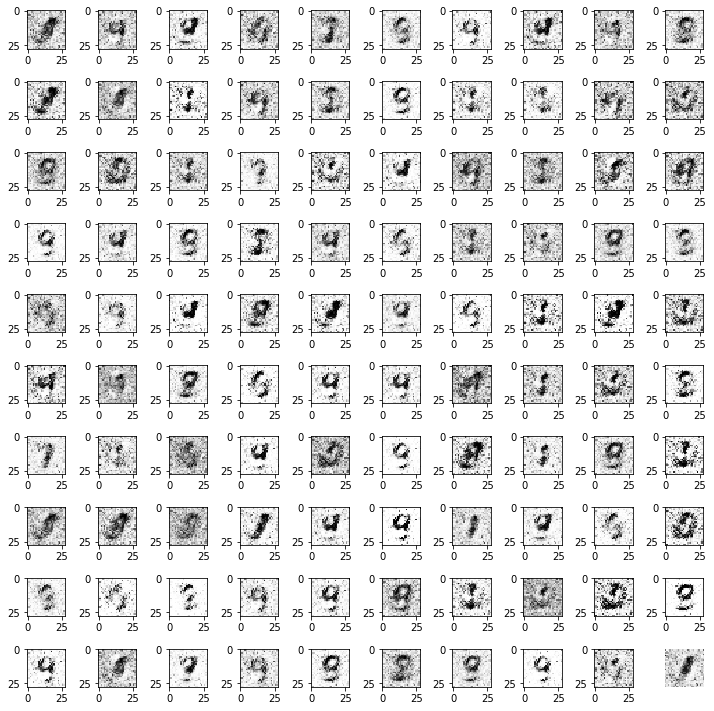

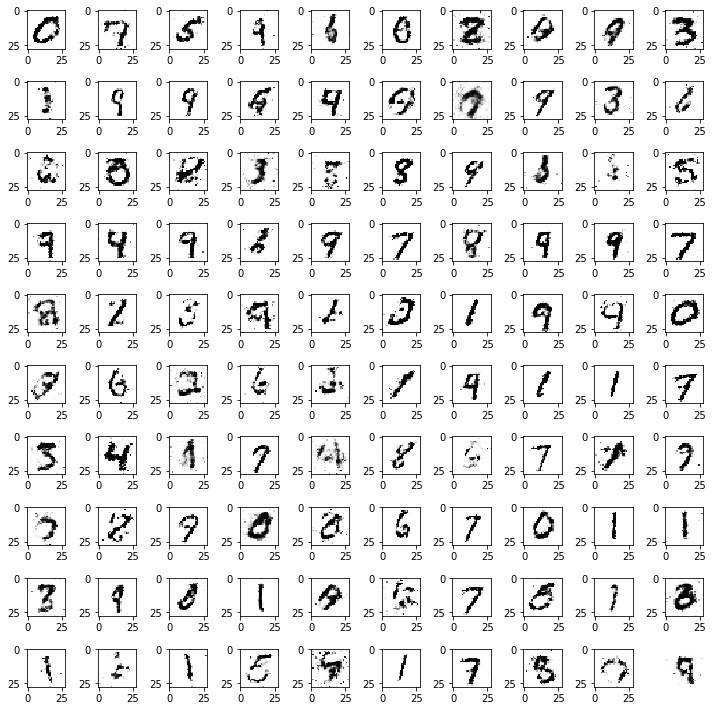

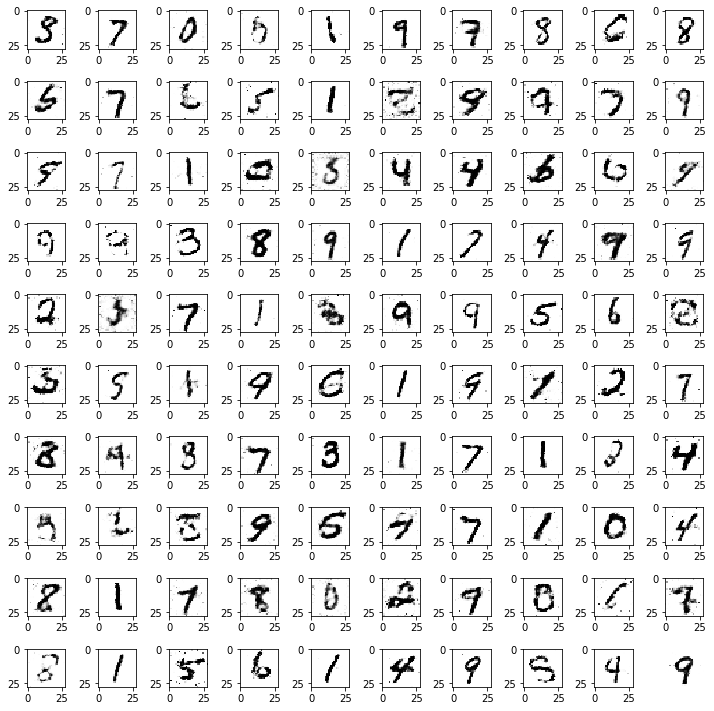

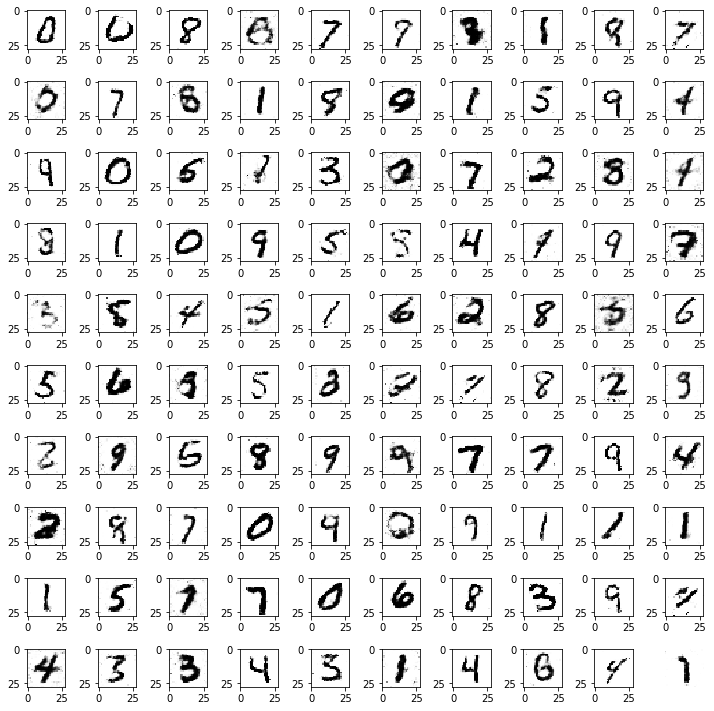

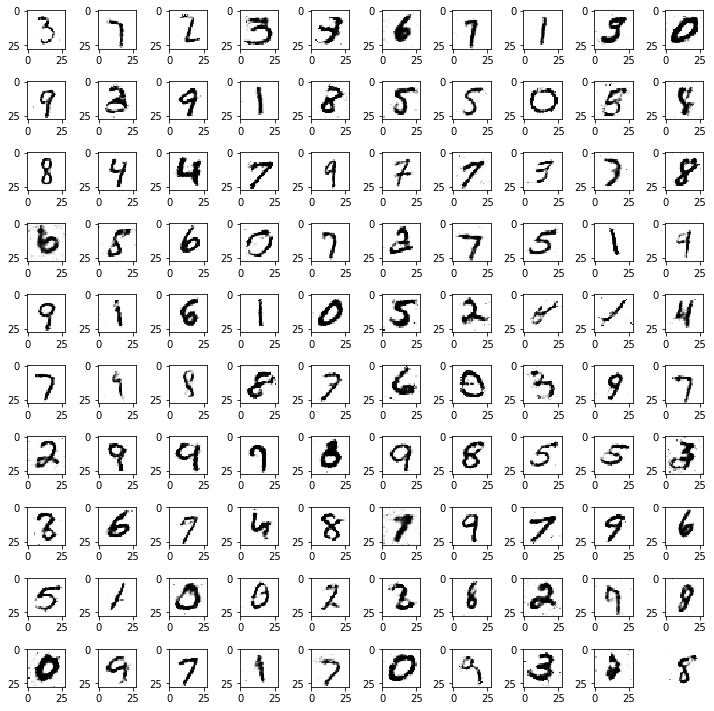

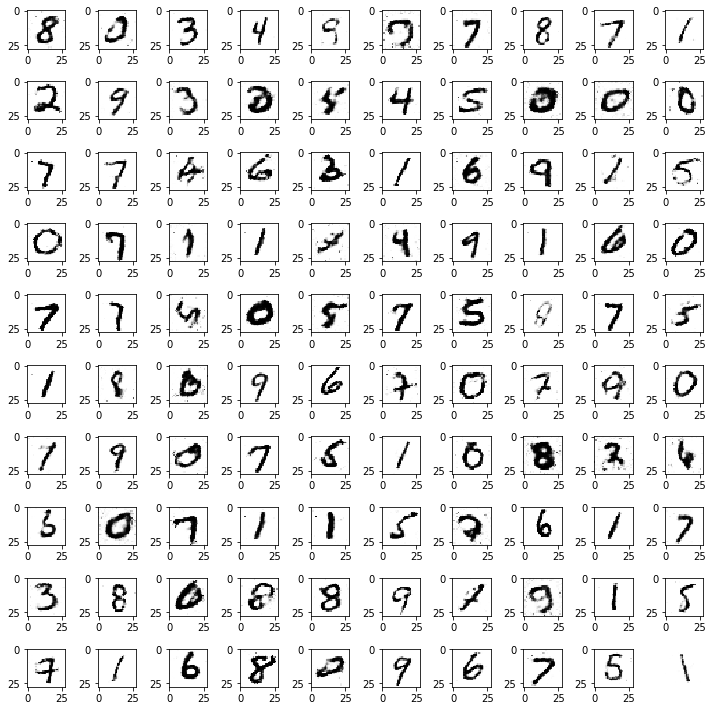

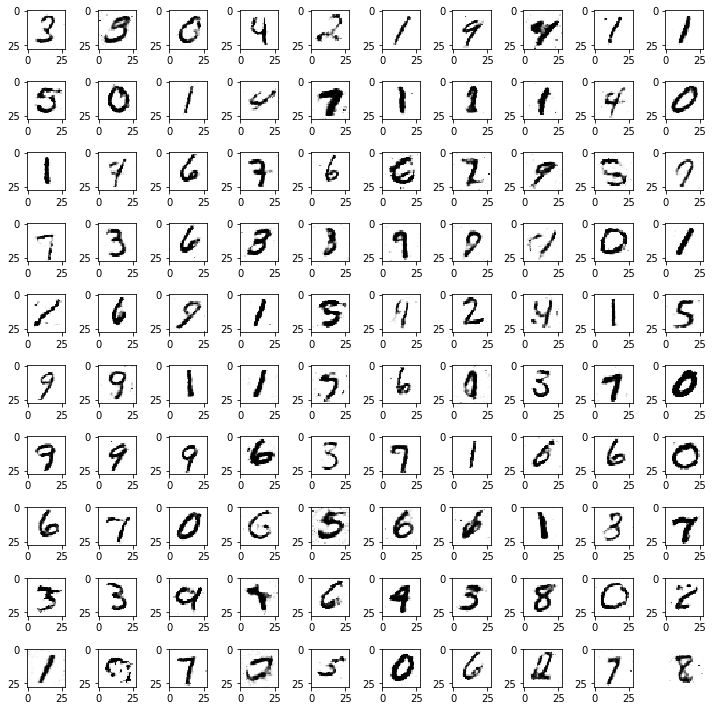

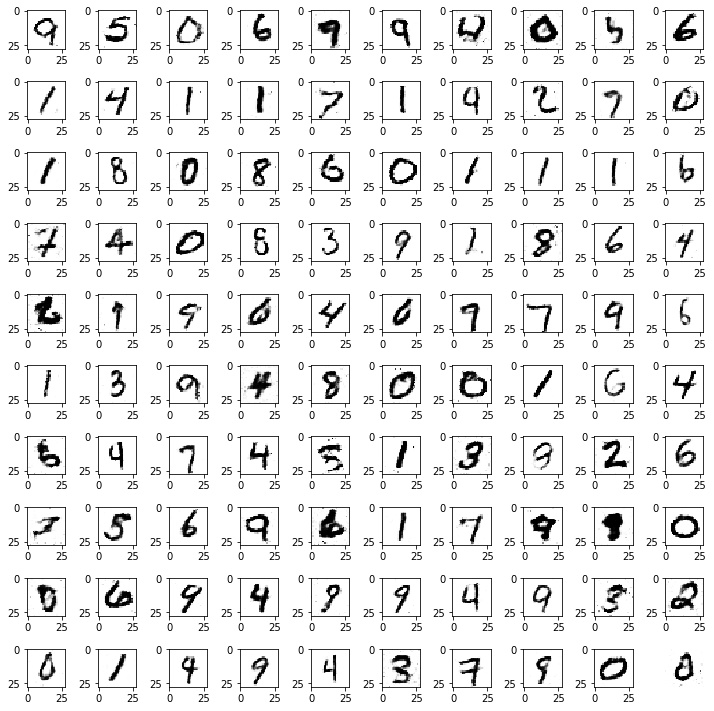

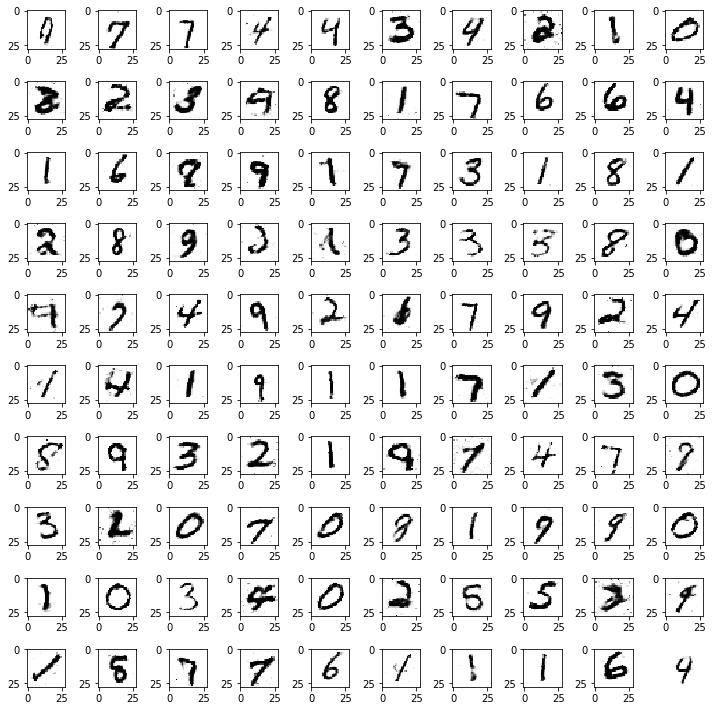

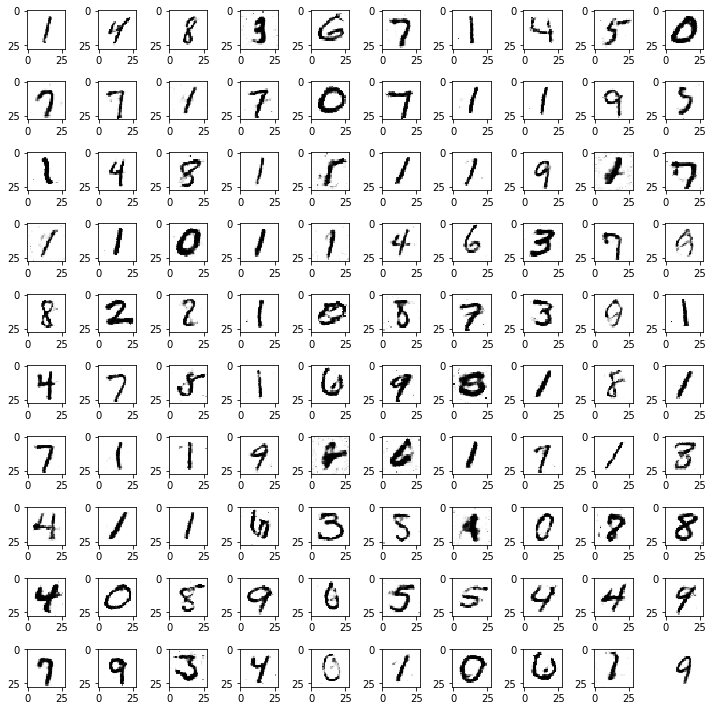

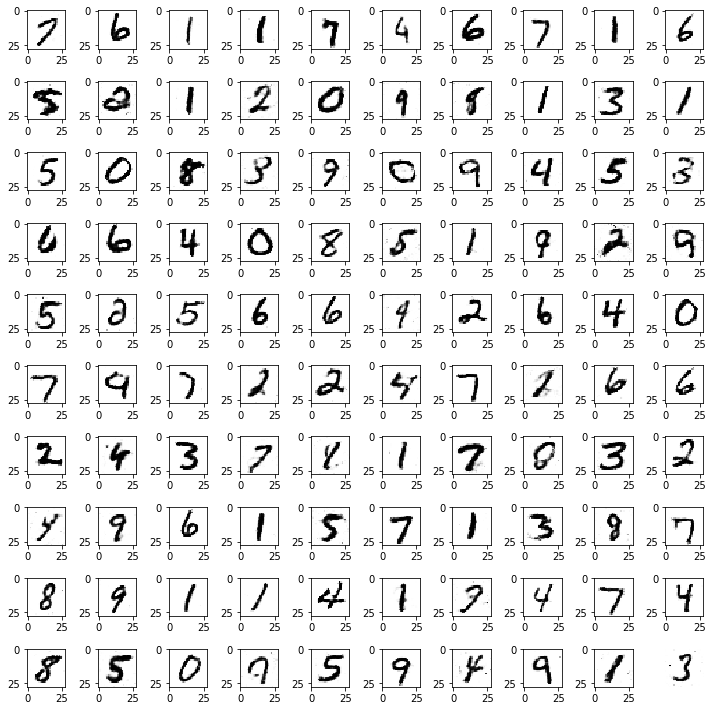

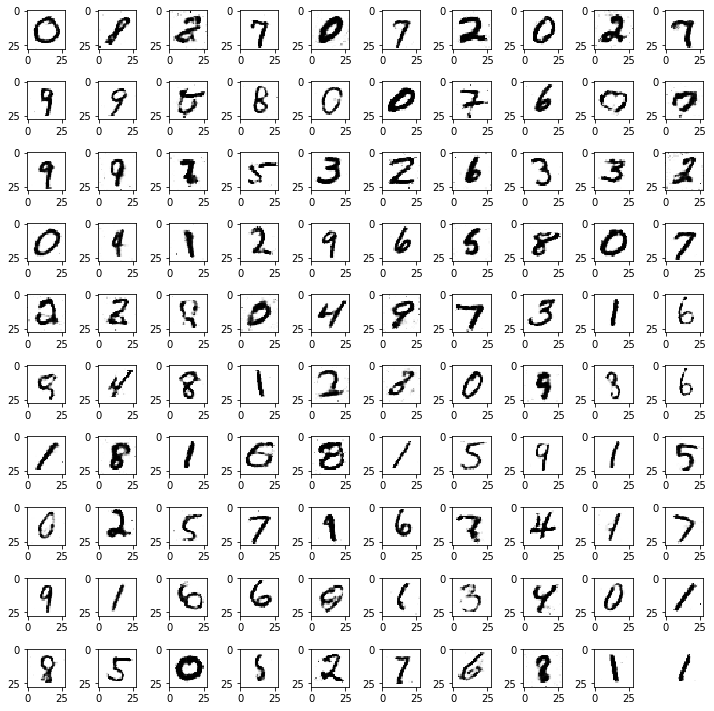

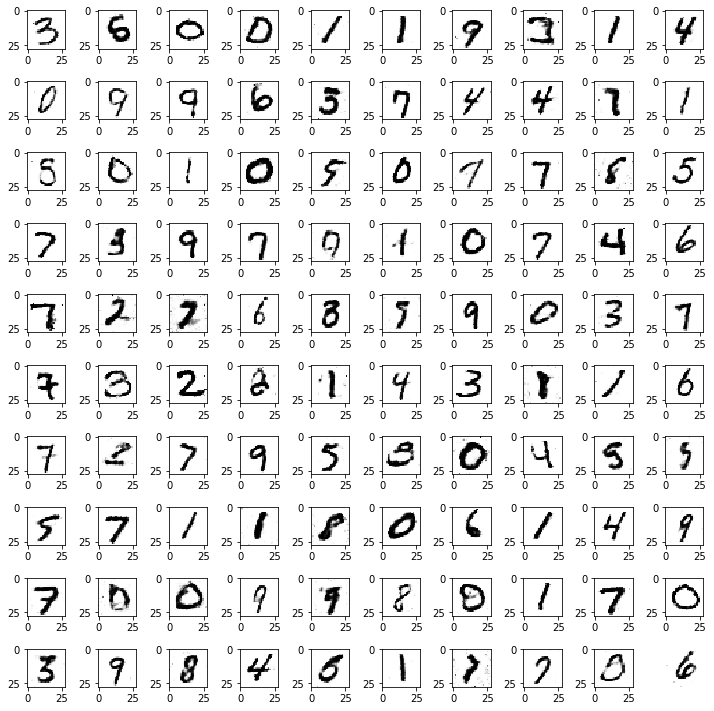

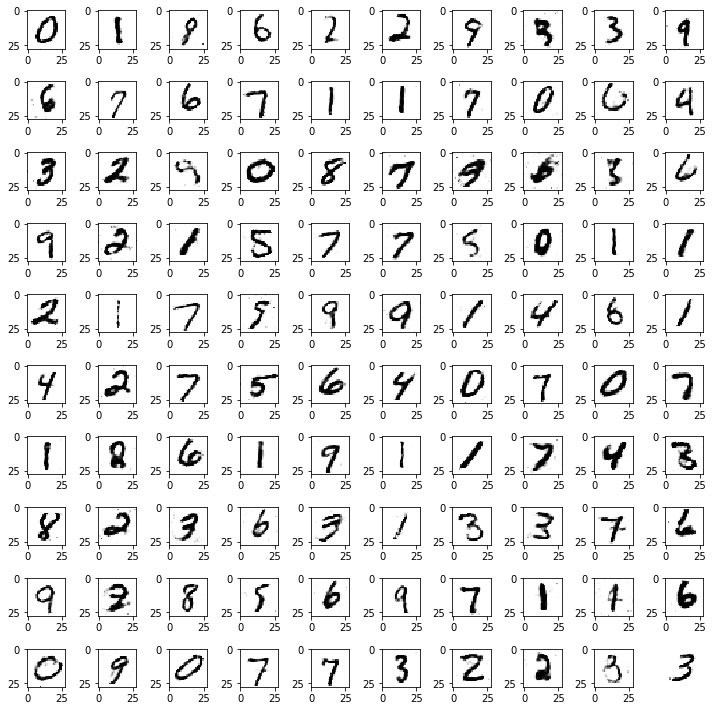

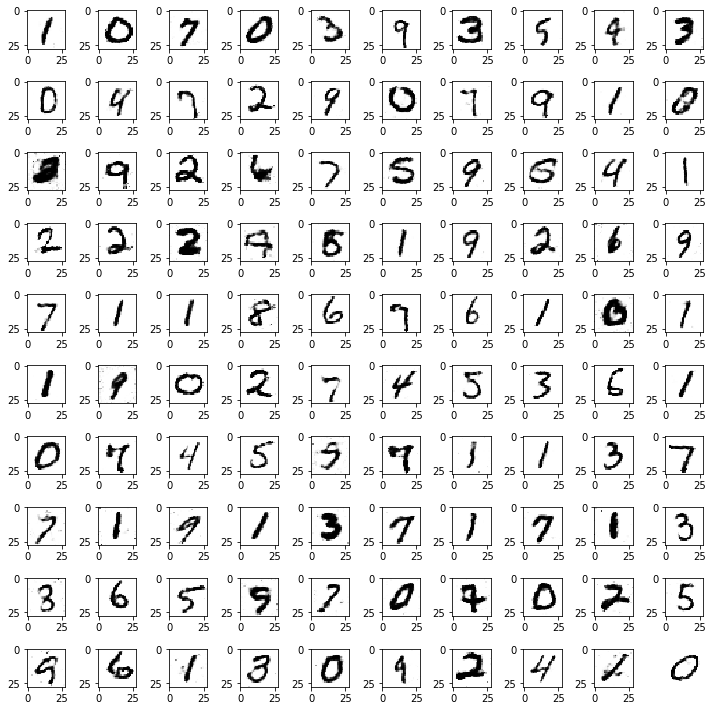

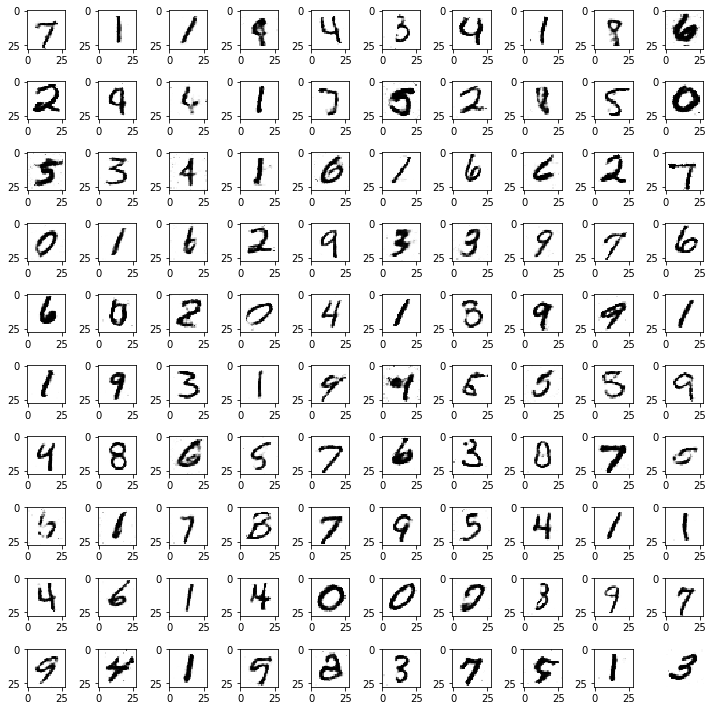

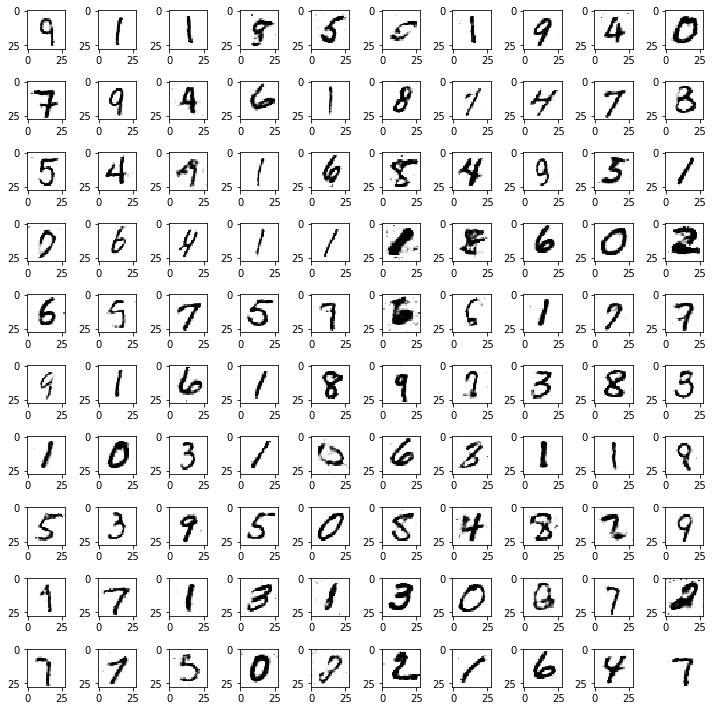

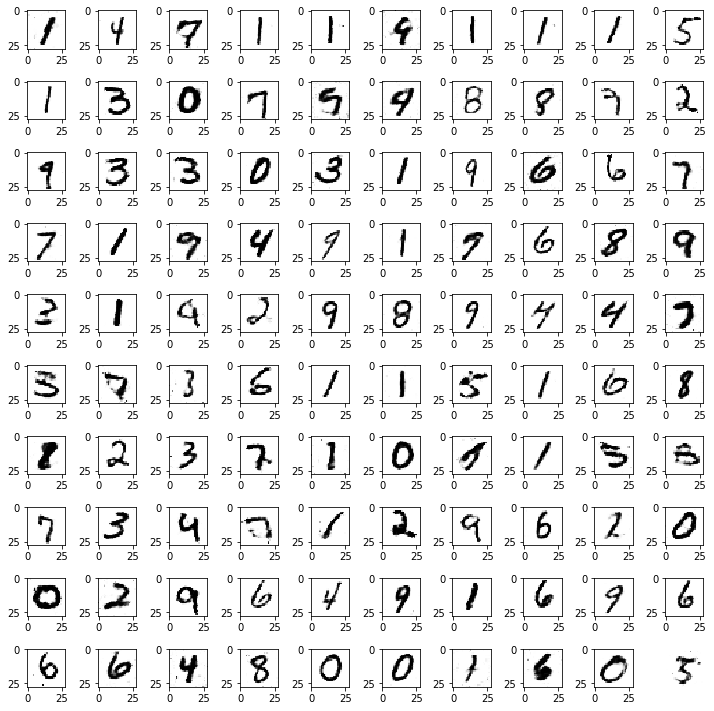

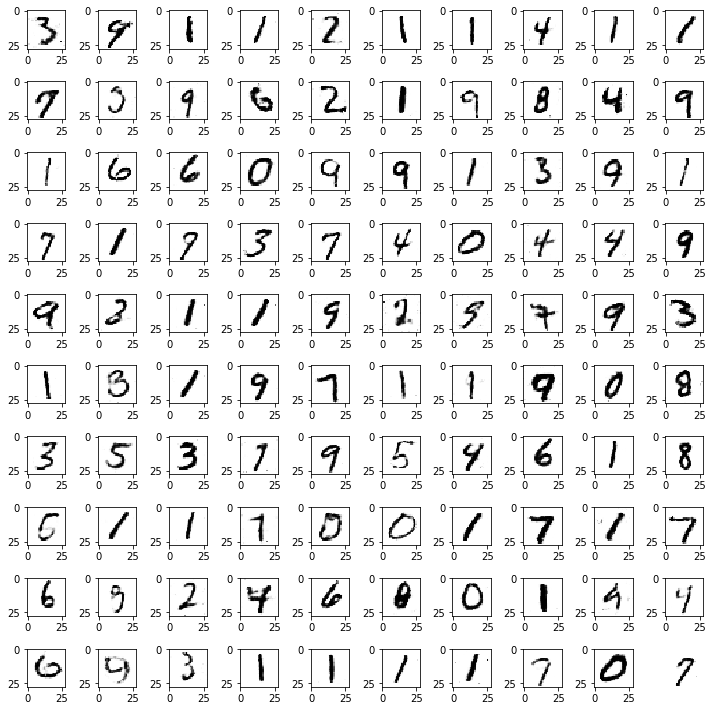

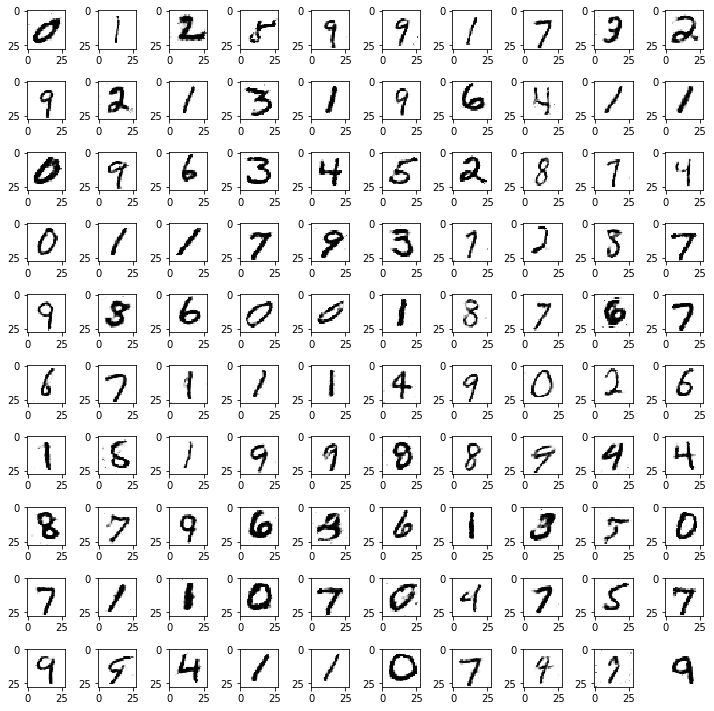

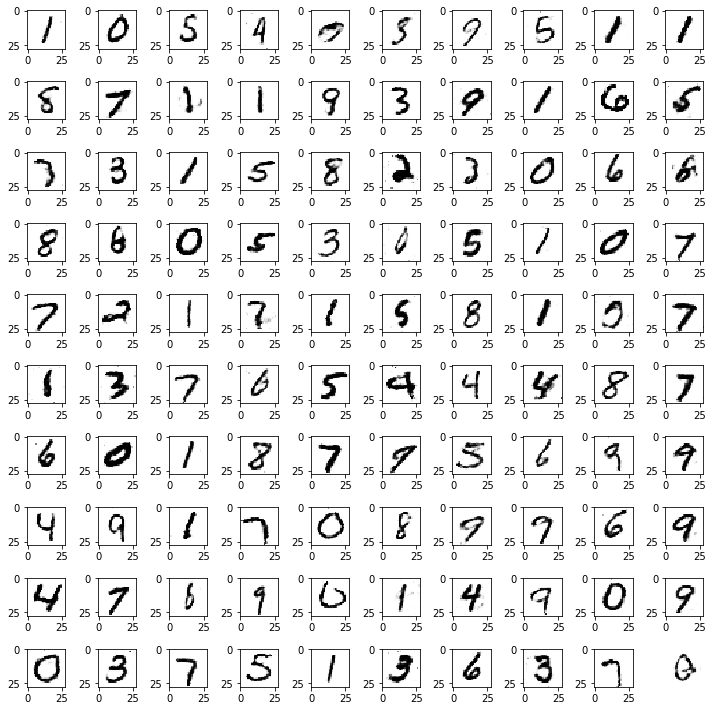

In [36]:
if __name__=='__main__':
    train_GAN(400, 128)